# Music genre classifier using fast.ai

> A side-project done while attending Practical Deep Learning for Coders Course

- toc: true
- branch: master
- badges: true
- hide_binder_badge: true
- comments: true
- author: Kurian Benoy
- categories: [fastai, fastbook]
- image: images/music.png                                                       
- hide: false
- search_exclude: false

During first lesson of Practical Deep Learning for Coders course, Jeremy had mentioned how using simple 
computer vision model we can build even a model to classify audio with image classification model itself.

Recently Kaggle grandmaster [Rob Mulla](https://www.kaggle.com/robikscube) conducted a challenge to classify music according to what genre it was. At stakes there was a RTX 3080 Ti GPU. Let's look how we can classify music genres using a simple computer vision model which was taught in the first lesson of fast.ai.

## Downloading packages and importing libraries

> Note: I had already installed fastai, pytorch for training this model before hand.

In [1]:
! pip install -Uqq kaggle git+https://github.com/huggingface/huggingface_hub#egg=huggingface-hub["fastai"]

In [2]:
# hide output
from fastai.data.all import *
from fastai.imports import *
from fastai.vision.all import *

from huggingface_hub import push_to_hub_fastai

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


## Collecting Data

In this piece of code, I will show you how you can download datasets from Kaggle in general and the datasets I had used for training model. Inorder to train models in audio, first convert the audio to a spectogram and throw an image model. Check this tweet from [Dien Hoa Truong](https://twitter.com/DienhoaT) who won a NVIDIA RTX 3080 Ti GPU in this competition.

> twitter: https://twitter.com/DienhoaT/status/1519785308715462656


For this competition you need two datasets:

1. [The competition data](https://www.kaggle.com/competitions/kaggle-pog-series-s01e02/data)
2. [Image data generated from converting audio to melspectograms in form of images](https://www.kaggle.com/datasets/dienhoa/music-genre-spectrogram-pogchamps)

The data provided here are over 20,000 royalty free song samples (30 second clips) and their musical genres. Your task is to create a machine learning algorithm capable of predicting the genres of unlabeled music files. Create features, design architectures, do whatever it takes to predict them the best.

[The code for downloading data from kaggle has been adopted from Jeremy's notebook](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners)

In [4]:
creds = ""

from pathlib import Path

cred_path = Path("~/.kaggle/kaggle.json").expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [5]:
path = Path("../input/kaggle-pog-series-s01e02")
path.ls()

(#6) [Path('input/kaggle-pog-series-s01e02/genres.csv'),Path('input/kaggle-pog-series-s01e02/sample_submission.csv'),Path('input/kaggle-pog-series-s01e02/test.csv'),Path('input/kaggle-pog-series-s01e02/test'),Path('input/kaggle-pog-series-s01e02/train.csv'),Path('input/kaggle-pog-series-s01e02/train')]

In [10]:
from zipfile import ZipFile
from kaggle import api

if not path.exists():
    api.competition_download_cli(str(path))
    ZipFile(f"{path}.zip").extractall(path)

100%|██████████| 9.05G/9.05G [07:54<00:00, 20.5MB/s]

In [12]:
! kaggle datasets download -d dienhoa/music-genre-spectrogram-pogchamps

100%|█████████████████████████████████████▉| 6.80G/6.80G [07:00<00:00, 14.7MB/s]
100%|██████████████████████████████████████| 6.80G/6.80G [07:00<00:00, 17.4MB/s]


## Quick EDA and Data Cleaning

In [17]:
df_train = pd.read_csv("../input/kaggle-pog-series-s01e02/train.csv")
df_train.head()

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.ogg,7,Instrumental
1,7358,007358.ogg,train/007358.ogg,2,Punk
2,20573,020573.ogg,train/020573.ogg,5,Folk
3,11170,011170.ogg,train/011170.ogg,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.ogg,1,Rock


In [18]:
df_train["filepath"] = df_train["filepath"].str.replace("ogg", "png")

**Shows a highly imbalanced dataset**

In [19]:
df_train["genre"].value_counts()

Rock                   3097
Electronic             3073
Punk                   2584
Experimental           1801
Hip-Hop                1761
Folk                   1215
Chiptune / Glitch      1181
Instrumental           1045
Pop                     945
International           814
Ambient Electronic      796
Classical               495
Old-Time / Historic     408
Jazz                    306
Country                 142
Soul-RnB                 94
Spoken                   94
Blues                    58
Easy Listening           13
Name: genre, dtype: int64

In [20]:
df_train.head()

,song_id,filename,filepath,genre_id,genre
0,10150,010150.ogg,train/010150.png,7,Instrumental
1,7358,007358.ogg,train/007358.png,2,Punk
2,20573,020573.ogg,train/020573.png,5,Folk
3,11170,011170.ogg,train/011170.png,12,Old-Time / Historic
4,16662,016662.ogg,train/016662.png,1,Rock


In [21]:
df_train = df_train.set_index("song_id")

In [22]:
# I noticed some of images are missing music-genre-spectrogram-pogchamps images which are in training data. So removed it
df_train = df_train.drop(
    [
        23078,
        3137,
        4040,
        15980,
        11088,
        9963,
        24899,
        16312,
        22698,
        17940,
        22295,
        3071,
        13954,
    ]
)

In [23]:
df_train.shape

(19909, 4)

## Loading Data using fastai DataLoaders

For creating this notebook, I spend a major portion of my time in cleaning and sorting out appropriate datablocks/dataloaders for training image models using fast.ai. This is something which you as a practitioner experience, compared to learning all the theory and backpropogation algorithm.

So let's see how we load this data using fast.ai. There are two approaches which we will discuss below. Both the approaches of loading data works, but the first approach as a disadvantage, which
I will tell in a moment.

**Approach 1. Using DataBlock and loading images**

- Create a data frame `temp_train` and create new column `is_valid`
- `is_valid` is default column named created for using [ColSplitter](https://docs.fast.ai/data.transforms.html#ColSplitter)
- Now set `get_x` which specifies the path of files for inputting data which is set as base_path+filename path: *lambda o:f'{path}/'+o.path*
- Now set `get_y` which specifies the variable to predict, ie the genre of music

In [ ]:
temp_train = df_train
temp_train.loc[:15000, "is_valid"] = True
temp_train.loc[15000:, "is_valid"] = False

In [14]:
path = Path("../input/music-genre-spectrogram-pogchamps/spectograms/")

In [15]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    splitter=ColSplitter(),
    get_x=lambda o: f"{path}/" + o.path,
    get_y=lambda o: o.genre,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(),
)

In [14]:
dls = dblock.dataloaders(temp_train)

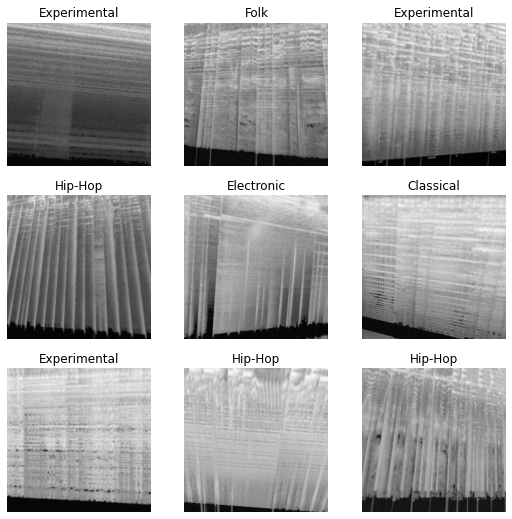

In [16]:
dls.show_batch()

In [17]:
# Can be used for debugging
# dblock.summary(df_train)

This worked really well, and with this approach I was even able to train a ML model which got 50% accuracy.

> twitter: https://twitter.com/kurianbenoy2/status/1520470393760272384


Yet when it came to export models, due to usage of **lamda method in DataBlock**. I got [Pickling error](https://gist.github.com/kurianbenoy/e672bf20831d14af47436300a4951fd5) as the model was not able to be exported with `learn.export()` method.

**2. Using DataLoaders methods with loading from dataframe method**

This issue got me into using approach that using `ImageDataLoaders.from_df` in fastai. Let's first take a look at our `df_train` dataframe:

In [24]:
df_train.head()

,filename,filepath,genre_id,genre
song_id,,,,
10150,010150.ogg,train/010150.png,7,Instrumental
7358,007358.ogg,train/007358.png,2,Punk
20573,020573.ogg,train/020573.png,5,Folk
11170,011170.ogg,train/011170.png,12,Old-Time / Historic
16662,016662.ogg,train/016662.png,1,Rock


If you look at the dataframe, we know that on appending to the path, the filepath column.
- This is the exact value for `get_x` method in fastai `fn_col = 1` which specifies the column name `filepath` at position 1.
- label or `get_y` is specified by the column name `genre` at position 3.
- valid_pct (ensure what percentage of data to be used for validation)
- y_block=CategoryBlock to ensure it's used for normal classification only and not multi-label

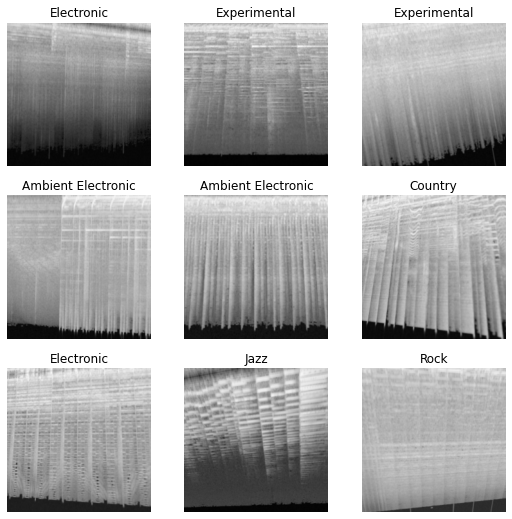

In [28]:
dls = ImageDataLoaders.from_df(
    df_train,
    path,
    valid_pct=0.2,
    seed=34,
    y_block=CategoryBlock,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224),
    fn_col=1,
    label_col=3,
)
dls.show_batch()

## Training fastai model

I trained using a `resnet18 model` at first, later we stepped up to use `resnet50` model.

In [29]:
learn = vision_learner(dls, resnet50, metrics=error_rate)

SuggestedLRs(valley=0.0008317637839354575)

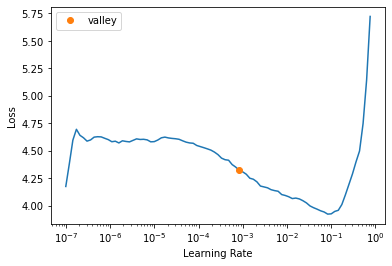

In [30]:
learn.lr_find()

In [31]:
learn.fine_tune(10, 0.0008317637839354575)

epoch,train_loss,valid_loss,error_rate,time
0,2.869285,2.171426,0.616428,01:43


epoch,train_loss,valid_loss,error_rate,time
0,2.312176,1.843815,0.558654,02:07
1,2.102361,1.719162,0.539061,02:08
2,1.867139,1.623988,0.527003,02:08
3,1.710557,1.527913,0.507661,02:07
4,1.629478,1.456836,0.479779,02:05
5,1.519305,1.433036,0.474253,02:05
6,1.457465,1.379757,0.464456,02:05
7,1.396283,1.369344,0.457925,02:05
8,1.359388,1.367973,0.453655,02:05
9,1.364363,1.368887,0.456167,02:04


In [32]:
learn.export("model.pkl")

## Pushing models to hugging face

`hugging_face_hub` had released a new fastai functions to easily push models. Just two functions are needed: `from_pretrained_fastai` and `push_to_hub_fastai`.

[Omar Espejel](https://twitter.com/espejelomar) had shared a fantastic notebook on [these new functionalities in huggingface here](https://colab.research.google.com/gist/omarespejel/9ba054ce74c7a4d4408085b611124bdf). 

> Note: You should install git-lfs and login to huggingface account with token before pushing

In [33]:
push_to_hub_fastai(
    learn,
    "kurianbenoy/music_genre_classification_baseline",
    commit_message="Resnet50 with 10 epochs of training",
)

/home/kurianbenoy/music_genre_classification_baseline is already a clone of https://huggingface.co/kurianbenoy/music_genre_classification_baseline. Make sure you pull the latest changes with `repo.git_pull()`.


Upload file model.pkl:   0%|          | 32.0k/98.4M [00:00<?, ?B/s]

To https://huggingface.co/kurianbenoy/music_genre_classification_baseline
   390320d..3605083  main -> main



'https://huggingface.co/kurianbenoy/music_genre_classification_baseline/commit/360508311005aefeb3ca29933f2173202afe4f30'

## Taking a look at results

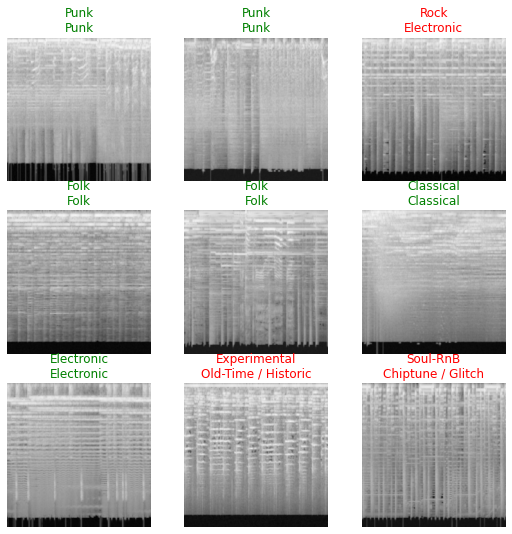

In [36]:
learn.show_results()

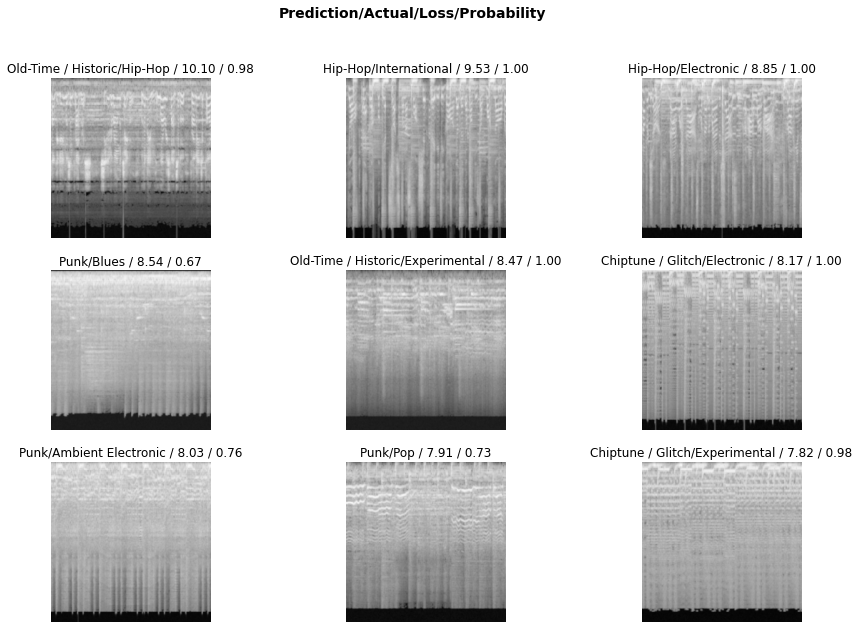

In [37]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15, 10))

## Conclusion

We trained a ML model which can identify with 54.4% accuracy to classify in a music file which genre it is. It's not so bad for a baseline model.
Dien Hoa Truong has shared some techniques which he learned during Kaggle competition with music genres. 

> twitter: https://twitter.com/DienhoaT/status/1520511289822433281



Thanks for reading :pray: